In [1]:
# !pip install SMOTE

In [2]:
# !pip install imbalanced-learn

In [3]:
# !pip install -U scikit-learn imbalanced-learn

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler


In [31]:
from functions import *

In [32]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [33]:
train.describe()

,overall
count,370863.000000
mean,4.566600
std,0.930377
min,1.000000
25%,5.000000
50%,5.000000
75%,5.000000
max,5.000000


In [34]:
train.head(20)

,overall,Review
0,5,I love these glitter pens. They sparkle deligh...
1,5,It works well with my machine. I use mostly c...
2,5,"This is a great assortment of colors, though t..."
3,5,Just what I was looking for.
4,5,I make 400 birds for the hospital each month.
5,1,not very sharp
6,5,Its just a replacement blade
7,5,"Great value,"
8,3,It is just okay for me. The plastic is a bit ...
9,5,Always happy when I find a great priced art gi...


In [35]:
train.isnull().sum()

overall    0
Review     8
dtype: int64

In [36]:
# train = train.dropna()

In [37]:
train.isnull().sum()

overall    0
Review     8
dtype: int64

In [38]:
train.duplicated().sum()

93449

In [39]:
train = train.drop_duplicates()

In [40]:
train.shape

(277414, 2)

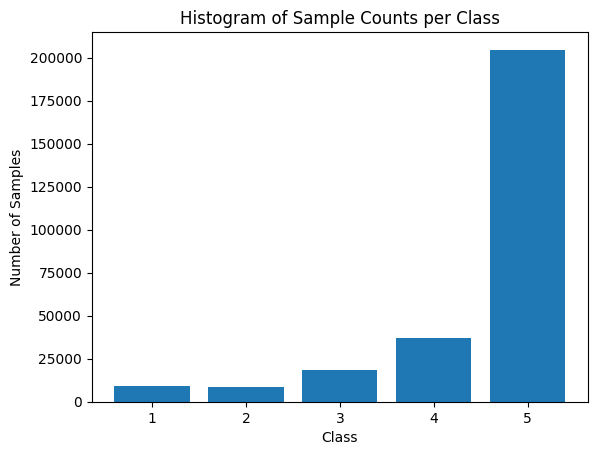

In [41]:
class_counts = train['overall'].value_counts()

plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Histogram of Sample Counts per Class')
plt.show()

In [42]:
test.describe()

,id
count,123622.000000
mean,61810.500000
std,35686.741826
min,0.000000
25%,30905.250000
50%,61810.500000
75%,92715.750000
max,123621.000000


In [43]:
test.head(20)

,id,Review
0,0,Wonderful asst. of wood carving tools
1,1,Pretty lace with 4 way stretch. I was exactly ...
2,2,This is a quick and easy way to start a crazy ...
3,3,"This is my favorite journals, the pages are ve..."
4,4,I bought this for a costume i was making. i wa...
5,5,Great idea but they don't cut well
6,6,Love this thread.
7,7,GOOD REUSABLE PRODUCT. MADE BAR LOTION WITH T...
8,8,After trial and error with various brands of a...
9,9,They are really smelly - like a vinyl shower c...


In [44]:
test.isnull().sum()

id        0
Review    4
dtype: int64

In [45]:
test.duplicated().sum()

0

In [46]:
test.shape

(123622, 2)

In [47]:
train["Review"]= train["Review"].astype(str)


In [48]:
train["Review"] = train["Review"].apply(preprocess)

In [23]:
train

,overall,Review
0,5,love glitter pen sparkle delightfully page bri...
1,5,work well machine use mostly cone
2,5,great assortment color though lot pink mix sti...
3,5,looking
4,5,make 400 bird hospital month
...,...,...
370856,5,perfect application bottle dispensing powdered...
370857,4,mainly purchased roll pencil case going gift s...
370858,5,love dy make great background card
370859,5,love darice embossing folder darcie folder rea...


In [24]:
# train = train.head(8000).copy()

In [49]:
vectorizer = TfidfVectorizer()

In [26]:
# vectorizer = CountVectorizer()

In [51]:
X = vectorizer.fit_transform(train["Review"])

In [55]:
y = train["overall"]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,test_size=0.3, random_state=42)
print('Original class distribution:', Counter(y_train))


Original class distribution: Counter({5: 143171, 4: 25754, 3: 12802, 1: 6567, 2: 5895})


In [57]:
undersampler = RandomUnderSampler(sampling_strategy={5: Counter(y_train)[4]}, random_state=42)
X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)

In [58]:
print('Class distribution after undersampling:', Counter(y_train_under))


Class distribution after undersampling: Counter({4: 25754, 5: 25754, 3: 12802, 1: 6567, 2: 5895})


In [59]:
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train_under, y_train_under)

In [60]:
print('Class distribution after SMOTE:', Counter(y_train_smote))


Class distribution after SMOTE: Counter({1: 25754, 2: 25754, 3: 25754, 4: 25754, 5: 25754})


In [62]:
model = RandomForestClassifier()
model.fit(X_train_smote, y_train_smote)

RandomForestClassifier()

In [64]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
y_train_pred = model.predict(X_train_smote)
print(classification_report(y_train_smote, y_train_pred))

              precision    recall  f1-score   support

           1       0.32      0.53      0.40      2815
           2       0.13      0.14      0.14      2526
           3       0.21      0.34      0.26      5486
           4       0.24      0.46      0.32     11038
           5       0.90      0.67      0.77     61360

    accuracy                           0.60     83225
   macro avg       0.36      0.43      0.38     83225
weighted avg       0.73      0.60      0.65     83225

              precision    recall  f1-score   support

           1       0.99      0.99      0.99     25754
           2       0.99      0.99      0.99     25754
           3       0.98      0.98      0.98     25754
           4       0.98      0.97      0.97     25754
           5       0.98      0.98      0.98     25754

    accuracy                           0.98    128770
   macro avg       0.98      0.98      0.98    128770
weighted avg       0.98      0.98      0.98    128770

